# Lagged cross-covariance analysis

Resolution: TransCom 3 regions, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [7]:
# Compute the monthly mean in each Transcom region
DS_tc = utils.read_transcom("../data/exp_pro/TRANSCOM_region_mask.nc")

df_sif_tc = (
    utils.map_transcom(DS_sif, DS_tc)
    .groupby(["region"])
    .resample("1MS")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)
df_xco2_tc = (
    utils.map_transcom(DS_xco2, DS_tc)
    .groupby(["region"])
    .resample("1MS")
    .mean()
    .drop(columns=["region"])
    .reset_index()
)

# Merge dataframes
# NOTE: all months present since 71*11 = 781
df_tc_monthly = pd.merge(df_sif_tc, df_xco2_tc, on=["region", "time"], how="left")
df_tc_monthly

,region,time,sif,xco2
0,1.0,2014-09-01,0.076657,392.668091
1,1.0,2014-10-01,0.033639,394.742004
2,1.0,2014-11-01,0.058322,397.809540
3,1.0,2014-12-01,NaN,399.142395
4,1.0,2015-01-01,0.068451,397.693054
...,...,...,...,...
776,11.0,2020-03-01,0.115146,414.438507
777,11.0,2020-04-01,0.192141,414.435455
778,11.0,2020-05-01,0.356506,413.789368
779,11.0,2020-06-01,0.517523,411.653442


In [8]:
# Check coverage
df_tc_counts = df_tc_monthly.dropna().groupby(["region"]).count()
df_tc_counts

,time,sif,xco2
region,,,
1.0,63,63,63
2.0,70,70,70
3.0,70,70,70
4.0,70,70,70
5.0,70,70,70
6.0,70,70,70
7.0,70,70,70
8.0,70,70,70
9.0,70,70,70


In [9]:
# Groupby region and compute cross-covariance
df_xcov_tc = (df_tc_monthly
              .drop(columns=["time"])
              .groupby(["region"])
              .apply(lambda group: stats.compute_xcov_1d(
                  group["sif"], 
                  group["xco2"], 
                  lag=4
              ))
              .reset_index(name="xcov")
             )

df_xcov_tc

,region,xcov
0,1.0,-0.117815
1,2.0,-0.143229
2,3.0,-0.001980
3,4.0,-0.014785
4,5.0,-0.041890
5,6.0,-0.038282
6,7.0,-0.282490
7,8.0,-0.042770
8,9.0,-0.040201
9,10.0,-0.040194


In [10]:
# Map covariance values to transcom grid dataset
df_regions = DS_tc.to_dataframe().dropna().reset_index()
ds_regions_xcov = (df_regions
                   .merge(df_xcov_tc, on=["region"])
                   .set_index(["lon", "lat"])
                   .to_xarray()
                  )

ds_regions_xcov

<xarray.Dataset>
Dimensions:  (lat: 137, lon: 338)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -54.5 -53.5 -52.5 -51.5 -50.5 ... 78.5 79.5 80.5 82.5
Data variables:
    region   (lon, lat) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    xcov     (lon, lat) float64 nan nan nan nan nan nan ... nan nan nan nan nan

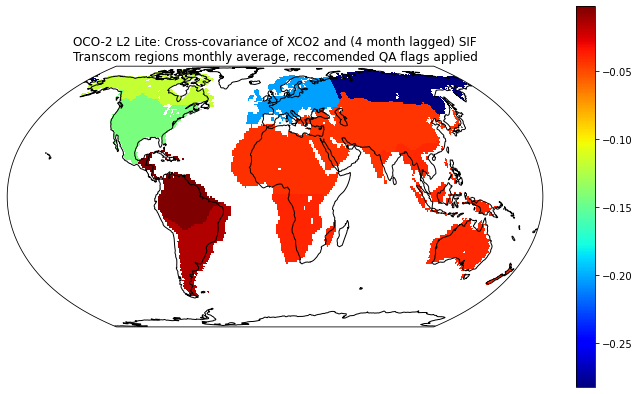

In [12]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": ccrs.EqualEarth()})

ax.set_global()
xarray.plot.imshow(ds_regions_xcov.xcov.T, robust=True, cmap="jet",
                   cbar_kwargs={"label": ""},
                   transform=ccrs.PlateCarree(), ax=ax)
ax.coastlines()
ax.set_title("OCO-2 L2 Lite: Cross-covariance of XCO2 and (4 month lagged) SIF\n" 
             "Transcom regions monthly average, reccomended QA flags applied")

plt.savefig("../plots/transcom_monthly_xcov.png");